In [1]:
from lib.functions0 import *
from lib.utility import *
import numpy as np
from scipy.linalg import expm
from qiskit.utils.mitigation.fitters import CompleteMeasFitter
from qiskit.ignis.mitigation.measurement import  complete_meas_cal
from qiskit import Aer, assemble, QuantumCircuit, QuantumRegister, ClassicalRegister, IBMQ, transpile, execute
from qiskit.providers.aer import AerSimulator, QasmSimulator
from qiskit.opflow import Zero, One, I, X, Y, Z
from qiskit.ignis.verification.tomography import state_tomography_circuits, StateTomographyFitter
from qiskit.quantum_info import state_fidelity
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')
IBMQ.load_account()

provider = IBMQ.get_provider(hub='ibm-q-community',
                            group='ibmquantumawards', 
                            project='open-science-22')
backend_sim_jakarta = QasmSimulator.from_backend(provider.get_backend('ibmq_jakarta'))
backend_real_jakarta = provider.get_backend('ibmq_jakarta')
backend_sim = Aer.get_backend('qasm_simulator')

#provider = IBMQ.get_provider(group='open', project='main')
#backend_real_belem = provider.get_backend('ibmq_lima')



In [2]:
import qiskit
qiskit.utils.mitigation.fitters.__file__

'/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/qiskit/utils/mitigation/fitters.py'

In [3]:
n_steps=100
time=np.pi/2
#initial_state={"110": 1}
shots = 20000
backend = backend_sim_jakarta

X = np.array([[0,1],[1,0]])  #defining the pauli matrices
Y = np.array([[0,-1j],[1j,0]])
Z = np.array([[1,0],[0,-1]])
Id = np.eye(2)

# defining the hamiltonian divided in: 
#       - H1: first two qubits interactions.
#       - H2: second two qubits interactions.

H1 = np.kron(X, np.kron(X,Id)) + np.kron(Y, np.kron(Y,Id)) + np.kron(Z, np.kron(Z,Id)) 
H2 = np.kron(Id, np.kron(X,X)) + np.kron(Id, np.kron(Y,Y)) + np.kron(Id, np.kron(Z,Z)) 

# building numerically the trotter step matrix, and the whole operator (trotter step)^n_steps.

trotter_step_matrix_= expm(-time/n_steps*H1*1j).dot(expm(-time/n_steps*H2*1j))
trotterized = np.linalg.matrix_power(trotter_step_matrix_, n_steps)
Matrix(trotterized).n(3, chop=True)

Matrix([
[-1.0,                   0,                   0,                   0,                   0,                   0,                   0,    0],
[   0,  0.333 + 0.000129*I, -0.667 + 0.000129*I,                   0, -0.667 - 0.000258*I,                   0,                   0,    0],
[   0, -0.667 + 0.000129*I,  0.333 - 0.000258*I,                   0, -0.667 + 0.000129*I,                   0,                   0,    0],
[   0,                   0,                   0,  0.333 + 0.000129*I,                   0, -0.667 + 0.000129*I, -0.667 - 0.000258*I,    0],
[   0, -0.667 - 0.000258*I, -0.667 + 0.000129*I,                   0,  0.333 + 0.000129*I,                   0,                   0,    0],
[   0,                   0,                   0, -0.667 + 0.000129*I,                   0,  0.333 - 0.000258*I, -0.667 + 0.000129*I,    0],
[   0,                   0,                   0, -0.667 - 0.000258*I,                   0, -0.667 + 0.000129*I,  0.333 + 0.000129*I,    0],
[   0,     

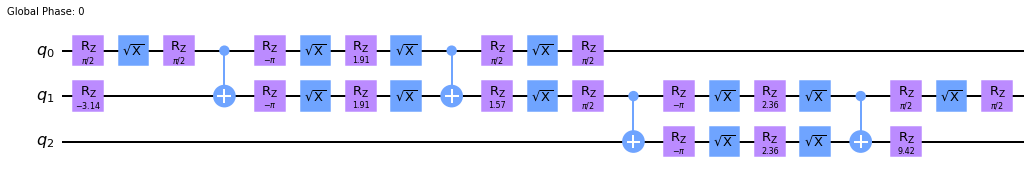

In [4]:
# phase_1_1, phase_2_1, phase_1_2, phase_2_2, a1, a2 = get_gates_parameters(trotterized, initial_state={"110": 1.0})

A0 = trotterized[3, 6]
A1 = trotterized[5, 6]
A2 = trotterized[6, 6]

r1=float(atan2(im(A0),re(A0))+atan2(im(A2),re(A2)))/2
r2=0
f1=float(atan2(im(A2),re(A2))-atan2(im(A1),re(A1))-np.pi)/2
f2=float((atan2(im(A2),re(A2))-atan2(im(A0),re(A0)))/2-f1)
a1=float(acos(abs(A2)))
a2=float(acos(abs(A1)/sin(a1)))

M1_qc = fixed_magnetization_two_qubit_gate(r1,f1,a1)
M2_qc = fixed_magnetization_two_qubit_gate(r2,f2,a2)

qr_U = QuantumRegister(3 ,name="q")
qc_U = QuantumCircuit(qr_U, name="U")

qc_U.append(M1_qc, [qr_U[0],qr_U[1]])
qc_U.append(M2_qc, [qr_U[1],qr_U[2]])

qc_U=transpile(qc_U, basis_gates=["cx","rz","x","sx"])
qc_U.draw(output="mpl")

In [5]:
U_ideal=matrix_from_circuit(qc_U, type="numpy")
Matrix(U_ideal)

Matrix([
[    0.999999924937793 - 0.000387458912036569*I,  -1.4465747670839e-16 - 6.12630955248374e-17*I,  8.24814415305182e-17 - 4.32600537053611e-17*I,   4.1634099270332e-17 + 1.75734092321137e-20*I, -4.72859494132749e-17 + 4.33306168435856e-17*I, -1.55737677535034e-17 - 3.78171014497583e-21*I,  4.81608103155982e-18 + 5.52236521085026e-21*I,               -2.6324058e-33 + 2.5896848e-33*I],
[ -1.4718793565973e-17 - 6.11468059032322e-17*I,     0.333333283254808 - 0.000129152960969951*I,     0.942808979670725 + 0.000365303063852142*I, -7.60981659821795e-17 + 4.33069368192824e-17*I,                 2.982223e-33 + 7.9322661e-33*I, -1.21774153146669e-17 + 1.44384170502726e-17*I, -7.77570174300182e-17 + 4.07922313454456e-17*I, -4.55670750006694e-18 + 2.49443475287084e-22*I],
[ 1.74808150379203e-16 - 6.11830973839661e-17*I,     0.666672729820377 + 0.000129152960974718*I,    -0.235704277955121 - 0.000228314788169758*I,   1.55609520582507e-17 + 4.3315199578126e-17*I,    -0.707100290481156 + 0.

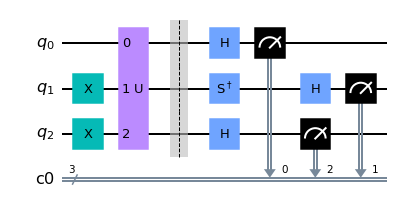

In [6]:
qr_evo = QuantumRegister(3, name="q")
qc_evo = QuantumCircuit(qr_evo, name="U")

qc_evo.x([qr_evo[1],qr_evo[2]])
qc_evo.append(qc_U, qr_evo)

qcs_tomo = state_tomography_circuits(qc_evo, qr_evo)
qcs_tomo[3].draw(output="mpl")

In [7]:
qr_cal = QuantumRegister(3)
cal_circ, state_labels = complete_meas_cal(qubit_list=[0,1,2], qr=qr_cal, circlabel='mcal')

In [8]:
cal_circ[0].draw()

░ ┌─┐      
q34_0: ─░─┤M├──────
        ░ └╥┘┌─┐   
q34_1: ─░──╫─┤M├───
        ░  ║ └╥┘┌─┐
q34_2: ─░──╫──╫─┤M├
        ░  ║  ║ └╥┘
 c1: 3/════╩══╩══╩═
           0  1  2

In [9]:
state_labels

['000', '001', '010', '011', '100', '101', '110', '111']

In [10]:
calib_circuits_identity = []
calib_circuits_itself = []

for i in state_labels:

    cr_cal_itself = ClassicalRegister(3)
    qr_cal_itself = QuantumRegister(3)
    qc_cal_itself = QuantumCircuit(qr_cal_itself, cr_cal_itself, name=f"mcalcal_{i}")

    cr_cal_id = ClassicalRegister(3)
    qr_cal_id = QuantumRegister(3)
    qc_cal_id = QuantumCircuit(qr_cal_id, cr_cal_id, name=f"mcalcal_{i}")

    qc_cal_id.append(qc_U, qr_cal_id)

    for k in range(3):
        if i[::-1][k] == "1":
            qc_cal_itself.x(qr_cal_itself[k])
            qc_cal_id.x(qr_cal_id[k])
        
    qc_cal_itself.append(qc_U, qr_cal_itself)
    
    qc_cal_id.measure(qr_cal_id, cr_cal_id)
    qc_cal_itself.measure(qr_cal_itself, cr_cal_itself)

    calib_circuits_identity.append(qc_cal_id)
    calib_circuits_itself.append(qc_cal_itself)

In [11]:
calib_circuits_identity[3].draw()

┌────┐┌───┐┌─┐   
q42_0: ┤0   ├┤ X ├┤M├───
       │    │├───┤└╥┘┌─┐
q42_1: ┤1 U ├┤ X ├─╫─┤M├
       │    │└┬─┬┘ ║ └╥┘
q42_2: ┤2   ├─┤M├──╫──╫─
       └────┘ └╥┘  ║  ║ 
 c9: 3/════════╩═══╩══╩═
               2   0  1

In [12]:
calib_circuits_itself[1].draw()

┌───┐┌────┐┌─┐      
q37_0: ┤ X ├┤0   ├┤M├──────
       └───┘│    │└╥┘┌─┐   
q37_1: ─────┤1 U ├─╫─┤M├───
            │    │ ║ └╥┘┌─┐
q37_2: ─────┤2   ├─╫──╫─┤M├
            └────┘ ║  ║ └╥┘
 c4: 3/════════════╩══╩══╩═
                   0  1  2

In [13]:
job_tomo=execute(qcs_tomo, backend, shots=shots, initial_layout=[0,1,2])

job_cal_our_identity=execute(calib_circuits_identity, backend = backend, shots=shots, initial_layout=[0,1,2])

job_cal_our_itself=execute(calib_circuits_itself, backend = backend, shots=shots, initial_layout=[0,1,2])

job_cal_qiskit=execute(cal_circ, backend, shots=shots, initial_layout=[0,1,2])

In [14]:
qiskit_raw_cal = deepcopy(job_cal_qiskit.result().get_counts())

# Mitigation:

    - building the calibration matrices

In [15]:
meas_fitter_our_identity = CompleteMeasFitter(job_cal_our_identity.result(), state_labels=state_labels)
meas_fitter_our_itself = CompleteMeasFitter(job_cal_our_itself.result(), state_labels=state_labels)
meas_fitter_qiskit = CompleteMeasFitter(job_cal_qiskit.result(), state_labels=state_labels)

In [45]:
Matrix(meas_fitter_qiskit.cal_matrix).n(3, chop=True)

Matrix([
[  0.935,  0.0535,  0.057, 0.00275, 0.0327,  0.0021,  0.0029, 0.00015],
[ 0.0229,   0.903,  0.001,  0.0548, 0.0005,  0.0352,       0,  0.0023],
[  0.032, 0.00165,   0.91,  0.0515, 0.0011,  0.0001,  0.0334,  0.0019],
[ 0.0009,  0.0325, 0.0215,   0.881,      0,  0.0012,  0.0013,  0.0323],
[0.00905, 0.00075, 0.0007,       0,  0.909,  0.0526,  0.0596,  0.0036],
[      0,  0.0083,      0,  0.0006, 0.0229,   0.874, 0.00145,  0.0556],
[ 0.0003,       0, 0.0102, 0.00055, 0.0324, 0.00265,   0.879,  0.0542],
[      0,  0.0002,      0,  0.0083, 0.0009,  0.0323,  0.0219,    0.85]])

In [46]:
not_migigated_qiskit = occurrences_to_matrix(qiskit_raw_cal)
Matrix(not_migigated_qiskit).n(3, chop=True)

Matrix([
[  0.935,  0.0535,  0.057, 0.00275, 0.0327,  0.0021,  0.0029, 0.00015],
[ 0.0229,   0.903,  0.001,  0.0548, 0.0005,  0.0352,       0,  0.0023],
[  0.032, 0.00165,   0.91,  0.0515, 0.0011,  0.0001,  0.0334,  0.0019],
[ 0.0009,  0.0325, 0.0215,   0.881,      0,  0.0012,  0.0013,  0.0323],
[0.00905, 0.00075, 0.0007,       0,  0.909,  0.0526,  0.0596,  0.0036],
[      0,  0.0083,      0,  0.0006, 0.0229,   0.874, 0.00145,  0.0556],
[ 0.0003,       0, 0.0102, 0.00055, 0.0324, 0.00265,   0.879,  0.0542],
[      0,  0.0002,      0,  0.0083, 0.0009,  0.0323,  0.0219,    0.85]])

In [18]:
#calib = np.linalg.multi_dot([migigated_qiskit, np.linalg.inv(not_migigated_qiskit)])
#Matrix(calib).n(2, chop=True)

In [19]:
U_tilde_identity=meas_fitter_our_identity.cal_matrix
U_tilde_itself=meas_fitter_our_itself.cal_matrix
U_tilde_qiskit=meas_fitter_qiskit.cal_matrix

In [20]:
def matrix_from_cirquit(qc, phase=0, type="sympy"):

    backend = Aer.get_backend('unitary_simulator')
    job = execute(qc, backend, shots=32000)
    result = job.result()
    A=result.get_unitary(qc, decimals=10)*np.exp(1j*phase)
    if type=="sympy":
        return Matrix(A)
    else:
        return A

In [21]:
qr_basi = QuantumRegister(3)
qc_basi = QuantumCircuit(qr_basi)

qcs_basis = state_tomography_circuits(qc_basi, qr_basi)

qcs_basis[0].remove_final_measurements()

qcs_basis[16].draw()

░ ┌─────┐ ┌───┐      ┌─┐   
q1172_0: ─░─┤ Sdg ├─┤ H ├──────┤M├───
          ░ └─┬─┬─┘ └───┘      └╥┘   
q1172_1: ─░───┤M├───────────────╫────
          ░   └╥┘  ┌─────┐┌───┐ ║ ┌─┐
q1172_2: ─░────╫───┤ Sdg ├┤ H ├─╫─┤M├
          ░    ║   └─────┘└───┘ ║ └╥┘
  c18: 3/══════╩════════════════╩══╩═
               1                0  2

In [22]:
C_matrices_itself = []
C_matrices_identity = []

U_ideal_inv = np.linalg.inv(U_ideal)
U_ideal_inv_abs = np.abs(U_ideal_inv)**2

U_ideal_abs = np.abs(U_ideal)**2
#print(type(U_ideal_abs))
#U_ideal_abs = np.asarray(Matrix(U_ideal_abs).n(10, chop=True), dtype='float64')
#print(type(U_ideal_abs))
U_ideal_abs_inv = np.linalg.inv(U_ideal_abs)

C_itself = np.dot(U_tilde_itself, U_ideal_abs_inv)
C_identity = U_tilde_identity

In [23]:
Matrix(U_ideal_abs).n(3, chop=True)
np.linalg.det(U_ideal_abs)

2.0056216300263255e-10

In [24]:
Matrix(np.dot(U_ideal_abs,np.linalg.inv(U_ideal_abs))).n(3, chop=True)

Matrix([
[1.0,   0,   0,   0,   0,   0,   0,   0],
[  0, 1.0,   0,   0,   0,   0,   0,   0],
[  0,   0, 1.0,   0,   0,   0,   0,   0],
[  0,   0,   0, 1.0,   0,   0,   0,   0],
[  0,   0,   0,   0, 1.0,   0,   0,   0],
[  0,   0,   0,   0,   0, 1.0,   0,   0],
[  0,   0,   0,   0,   0,   0, 1.0,   0],
[  0,   0,   0,   0,   0,   0,   0, 1.0]])

In [25]:
Matrix(U_ideal_abs_inv)

Matrix([
[                  1.0, -6.38828774305325e-33, -6.27526215798912e-28, -4.78235868964663e-29,  6.27495137010403e-28, 4.78218616386323e-29, -2.73877620187348e-34, -5.35661892079167e-61],
[ -2.1706632573387e-28,    -0.142857115240523,       31383.465267128,   3.7903135058346e-24,     -31382.3224100128, -3.7904515460301e-24,  1.03241752404799e-28,  2.96622562553002e-36],
[ 2.71288361058897e-29,       1.1428571152422,     -3922.93249486577, -4.73755313974067e-25,      3922.78963775053, 4.73772550515136e-25, -1.29044364232091e-29, -2.37298089177954e-35],
[-1.13307071509665e-33,   1.0038473021028e-28, -4.04578068834702e-24,      27460.5327722646,  4.04563335760432e-24,    -27459.5327722645, -1.65059402738116e-12,  3.07576526827197e-28],
[ 1.89871847134738e-28,  -1.6741818010303e-12,     -27459.5327722622, -3.31645887164564e-24,      27460.5327722622, 3.31657964787658e-24, -9.03641342071608e-29, -1.73339853088769e-33],
[-2.37304953401705e-35,  1.43414804440885e-29, -5.76871110794403e-

In [26]:
Matrix(C_itself)

Matrix([
[0.89715,   0.058464285933854,  514.542640125998,  117.495320086471, -514.424004411932, -117.484098657817,   0.00732857134572024, 0.00085],
[0.02605,   0.861749981597565,  90.6219134892806,  423.726342079872, -90.6153134708783, -423.611870652368, -0.000171427504145635,  0.0062],
[0.04665, 0.00347143806814932,  381.544454762095,  84.1726911799619, -380.667076200165, -84.1180554652096,    0.0475142852475921,  0.0043],
[  0.003,  0.0466285707464879, -4.88859783610602, -12.9123374151494,  4.91851926535958,  13.7626231203333,   0.00161429481609374, 0.04405],
[ 0.0202, 0.00540000906587971, -465.011829444512, -36.0628494347634,  465.883779435447,  36.1178637214897,    0.0752857132736375,  0.0063],
[  0.002,  0.0199999998453565, -19.2088686940221,  27.6864387857788,  19.2351686941768, -26.8418316518639,   0.00549286608449744,  0.0679],
[0.00485, 0.00012142910850988, -405.591413128063, -112.190896393298,  405.656441698955,  112.197782125467,     0.838114267831009,  0.0539],
[ 0.0001, 0

In [27]:
np.linalg.det(np.abs(trotterized)**2)

0.012345679061769449

In [28]:

for base in qcs_basis:
    
    '''
    base.remove_final_measurements()

    base_matrix = np.matrix(matrix_from_cirquit(base, type="numpy"))
    base_matrix_H = base_matrix.getH()

    C_aus_itself = np.linalg.multi_dot([U_tilde_qiskit, base_matrix, np.linalg.inv(U_tilde_qiskit), C_itself,  base_matrix_H])
    #C_aus_itself = np.linalg.multi_dot([base_matrix, U_tilde_qiskit, np.linalg.inv(U_tilde_qiskit), C_itself])
    C_aus_identity = np.dot(base_matrix, C_identity).dot(base_matrix_H)

    C_matrices_identity.append(np.asarray(C_aus_identity))
    C_matrices_itself.append(np.asarray(C_aus_itself))
    '''

    base.remove_final_measurements()

    base_matrix_amplitudes = matrix_from_cirquit(base, type="numpy")
    base_matrix_amplitudes_inverse = np.linalg.inv(base_matrix_amplitudes)
    
    base_matrix = np.abs(base_matrix_amplitudes)**2
    base_matrix_inverse = np.abs(base_matrix_amplitudes_inverse)**2

    #C_aus_itself = np.linalg.multi_dot([base_matrix, C_itself,  base_matrix_inverse])
    C_aus_itself = np.linalg.multi_dot([U_tilde_qiskit, base_matrix, np.linalg.inv(U_tilde_qiskit), C_itself,  base_matrix_inverse])
    C_aus_itself = np.linalg.multi_dot([U_tilde_qiskit, base_matrix, np.linalg.inv(U_tilde_qiskit), C_itself,  np.transpose(base_matrix)])
    

    C_aus_identity = np.linalg.multi_dot([U_tilde_qiskit, base_matrix, np.linalg.inv(U_tilde_qiskit), C_identity,  base_matrix_inverse])
    #C_aus_identity = np.linalg.multi_dot([base_matrix, C_identity, base_matrix_inverse])

    C_matrices_identity.append(np.asarray(C_aus_identity))
    C_matrices_itself.append(np.asarray(C_aus_itself))

In [29]:
from copy import deepcopy

meas_fitters_identity = []
meas_fitters_itself = []

for C_new in C_matrices_identity:
    meas_fitter_our_aus = deepcopy(meas_fitter_our_identity)
    meas_fitter_our_aus._tens_fitt.cal_matrices[0]=C_new

    meas_fitters_identity.append(meas_fitter_our_aus)

for C_new in C_matrices_itself:
    meas_fitter_our_aus = deepcopy(meas_fitter_our_itself)
    meas_fitter_our_aus._tens_fitt.cal_matrices[0]=C_new

    meas_fitters_itself.append(meas_fitter_our_aus)

In [30]:
target_state = (One^One^Zero).to_matrix()
#target_state = (Zero^One^One).to_matrix()


fids=np.zeros(4)

raw_res=deepcopy(job_tomo.result())
qiskit_res=deepcopy(raw_res)
identity_res=deepcopy(raw_res)
itself_res=deepcopy(raw_res)

In [31]:
raw_res.get_counts(-1)

{'110': 1951,
 '100': 648,
 '001': 882,
 '111': 746,
 '011': 7609,
 '101': 7529,
 '000': 74,
 '010': 561}

In [32]:
for i in range(27):

    old_counts=raw_res.get_counts(i)
    new_counts_qiskit = meas_fitter_qiskit.filter.apply(old_counts, method="least_squares")
    qiskit_res.results[i].data.counts = new_counts_qiskit

    old_counts=raw_res.get_counts(i)
    
    new_counts_id = meas_fitters_identity[i].filter.apply(old_counts, method="least_squares")
    identity_res.results[i].data.counts = new_counts_id

    new_counts_it = meas_fitters_itself[i].filter.apply(old_counts, method="least_squares")
    itself_res.results[i].data.counts = new_counts_it

In [34]:
raw_res.get_counts(-1)

{'110': 1951,
 '100': 648,
 '001': 882,
 '111': 746,
 '011': 7609,
 '101': 7529,
 '000': 74,
 '010': 561}

In [35]:
itself_res.get_counts(-1)

{'000': 1.8482785793418955e-18,
 '001': 3.848672611997582e-18,
 '010': 5.809691804477971e-18,
 '011': 8904.618891096425,
 '100': 0.007285885196431262,
 '101': 8904.914231584638,
 '110': 2190.459591433777,
 '111': 4.3036675741058855e-18}

In [36]:
identity_res.get_counts(-1)

{'000': 3.890414822798028e-10,
 '001': 1.3511664931318297e-09,
 '010': 9.249417810229488e-10,
 '011': 8924.359586290264,
 '101': 8811.65624229043,
 '110': 2173.566499854986,
 '111': 90.4176715619419}

In [37]:
fids[0] = fidelity_count(raw_res, qcs_tomo, target_state)
fids[1] = fidelity_count(qiskit_res, qcs_tomo, target_state)
fids[2] = fidelity_count(identity_res, qcs_tomo, target_state)
fids[3] = fidelity_count(itself_res, qcs_tomo, target_state)

fids

array([0.0997609 , 0.10942193, 0.11267242, 0.08390077])

In [38]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})  # enlarge matplotlib fonts

# Import qubit states Zero (|0>) and One (|1>), and Pauli operators (X, Y, Z)
from qiskit.opflow import Zero, One, I, X, Y, Z

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Returns the matrix representation of the XXX Heisenberg model for 3 spin-1/2 particles in a line
def H_heis3():
    # Interactions (I is the identity matrix; X, Y, and Z are Pauli matricies; ^ is a tensor product)
    XXs = (I^X^X) + (X^X^I)
    YYs = (I^Y^Y) + (Y^Y^I)
    ZZs = (I^Z^Z) + (Z^Z^I)
    
    # Sum interactions
    H = XXs + YYs + ZZs
    
    # Return Hamiltonian
    return H

# Returns the matrix representation of U_heis3(t) for a given time t assuming an XXX Heisenberg Hamiltonian for 3 spins-1/2 particles in a line
def U_heis3(t):
    # Compute XXX Hamiltonian for 3 spins in a line
    H = H_heis3()
    
    # Return the exponential of -i multipled by time t multipled by the 3 spin XXX Heisenberg Hamilonian 
    return (t * H).exp_i()

In [39]:
initial_state = One^One^Zero

#((initial_state @ U_heis3(float(time)) @ initial_state).eval())**2
np.abs((~initial_state @ U_heis3(float(time)) @ initial_state).eval())**2

0.11111111111111122

In [40]:
matrix=1/np.sqrt(2)*np.array([[1,1],[1,-1]])
np.linalg.inv(matrix)

array([[ 0.70710678,  0.70710678],
       [ 0.70710678, -0.70710678]])